In [121]:
from SimDataDB import *
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]
# Macro for making consistent color+markers throughout
from itertools import cycle
from collections import defaultdict
colors = cycle("rgbycmk")
markers = cycle("+x*d")
colorkey = defaultdict(lambda :colors.next())
markerkey = defaultdict(lambda :markers.next())
mykwargs = lambda s:{'color':colorkey[s],'marker':markerkey[s],'label':s}
sdb = SimDataDB('PeriFlakes/results_ficticious_nu0.db')

In [138]:
H = 2.0 ; T = 1.0 ; E = 1.0 ; nu = 0.0;
solutions = \
    {'uniaxial': lambda x : [ 0,
                  T*(x[1]+H/2.0)*(2.0*nu**2+nu-1.0)/(E*(nu-1)) ],
     'isotropic':lambda x : [ T*(x[1]+H/2.0)*(1.0-nu-2.0*nu**2)/E,
                  T*(x[1]+H/2.0)*(1.0-nu-2.0*nu**2)/E ],
      'shear':   lambda x: [ 2.0*T*(x[1]+H/2.0)*(1.0+nu)/E, 0]
    }

In [139]:
def fetch(table,surf,method,N,weight='cubic',RF=1.5):
    return sdb.Query("""
            SELECT N,x,u FROM {table} WHERE 
            surface='{surface}' and method='{method}' 
            and weight='{weight}' and N={N} and RF={RF}""".format(
            table=table,surface=surf,method=method,weight=weight,N=N,RF=RF))

none


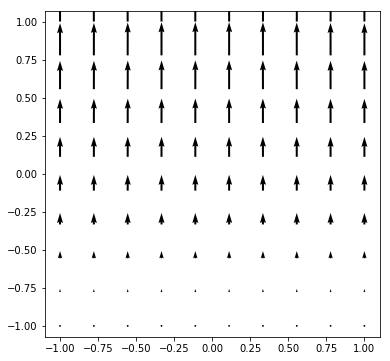

trivial


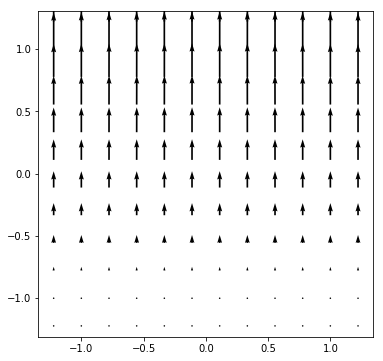

bobaru


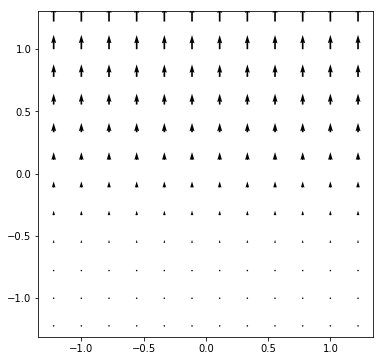

In [140]:
for surf in ['none','trivial','bobaru']:
    N,x,u = fetch('uniaxial',surf,'Silling',10,weight='const')[0]
    print surf
    N = int((u.shape[0]/2)**0.5)

    u = u.reshape(N,N,2)
    x = x.reshape(N,N,2)
    #ua = 
    ax = plt.gca()
    ax.quiver(x[:,:,0],x[:,:,1],u[:,:,0],u[:,:,1],angles='uv',scale_units='xy',scale=10)
    ax.set_aspect('equal', 'datalim')
    plt.show()

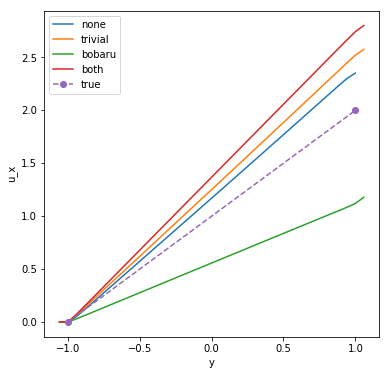

In [141]:
for surf in ['none','trivial','bobaru','both']:
    Ns = [_[0] for _ in sdb.Query("SELECT DISTINCT method FROM uniaxial")]
    
    N,x,u = fetch('uniaxial',surf,'Silling',35,weight='cubic')[0]
    
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    x = x.reshape(N,N,2)
    plt.plot(x[:,N/2,1],u[:,N/2,1],label=surf)
plt.plot([-1,1],[0,solutions['isotropic']([0,1])[1]],'o--',label="true")
plt.xlabel('y'); plt.ylabel('u_x');
plt.legend(loc=2)
plt.show()

In [142]:
def e(tab,met,surf):
    res = sdb.Query("SELECT N,x,u FROM {0} WHERE surface='{1}' and method='{2}' and weight='cubic' and RF=1.5".format(tab,surf,met))
    errors = []
    hs = []
    for N,x,u in res:
        n2 = int((u.shape[0]/2)**0.5)
        u = u.reshape(n2,n2,2)
        x = x.reshape(n2,n2,2)
        xc = list(x[n2/2,n2/2,:])
        diff = (u[n2/2,n2/2,0] - solutions[tab](xc)[0]).mean()
        errors.append(np.abs(diff/sum(solutions[tab](xc))))
        hs.append(2.0/float(N))
    return (hs,errors)

Silling


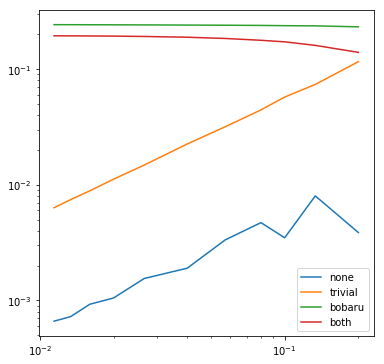

Fbased


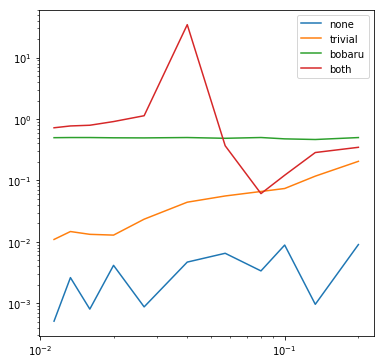

Fstab_Silling


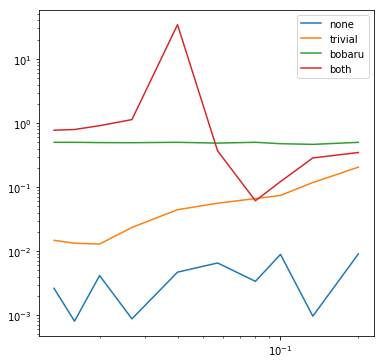

Oterkus2


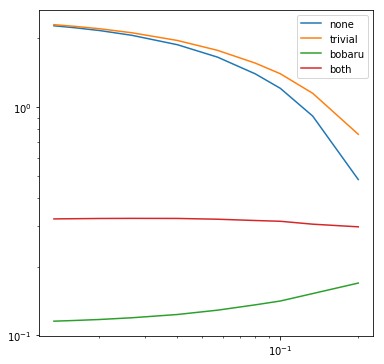

In [143]:
for m in ['Silling','Fbased','Fstab_Silling','Oterkus2']:
    print m
    for s in ['none','trivial','bobaru','both']:
        plt.loglog(*e('isotropic',m,s),label=s)
    plt.legend()
    plt.show()